# Анализ групп клиентов фитнес-клуба и прогнозирование оттока

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

**Цель**: 
- определить основные группы клиентов фитнес-клуба; 
- подготовить план действий по удержанию клиентов;

**Задачи:**
- Загрузка данных и подготовка их к анализу;
- Исследовательский анализ данных (средние в группах оттока, распределение признаков групп оттока, построение матрицы корреляций);
- Построение модели прогнозирования оттока клиентов (разбиение данных на обучающую и валидационную выборки, обучение модели логистической регрессией и методом случайного леса, оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке, сравнение моделей);
- Кластеризация клиентов финтес-клуба методом K-Means (прогнозирование количества кластеров, изучение средних значений признаков для кластеров, посмтроение распределений признаков для кластеров, сравнение долей оттока по каждому кластру);
- Общие выводы и рекомендации;

**Описание данных:**

Файл /datasets/gym_churn.csv:

Данные клиента за предыдущий до проверки факта оттока месяц:

    'gender' — пол;
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    'Phone' — наличие контактного телефона;
    'Age' — возраст;
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

    'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    'Group_visits' — факт посещения групповых занятий;
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    'Churn' — факт оттока в текущем месяце.


## Загрузка и подготовка данных к анализу 

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

from itertools import combinations

In [16]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')

In [17]:
df.shape

(4000, 14)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [19]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [20]:
print('Количество пропусков: \n', df.isnull().sum())
print('\nКоличество дубликатов:', df.duplicated().sum())

Количество пропусков: 
 gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Количество дубликатов: 0


Приведем названия столбцов к нижнему регистру (в остальном они соответствуют правилам написания.)

In [21]:
df.columns = df.columns.str.lower()
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

In [22]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [23]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Если посмотреть на средние в нашем датасете, то мы увидим, для выборки характерно:

- Клиенты живут или работают в районе клуба;
- Около половины - сотрудники компании-партнера;
- Не очень часто приходят по рекомендации;
- Договор в среднем на 5 месяцев;
- Умеренно активно посещают групповые занятия;
- В возрасте около 30 лет;
- Посещают клуб в течение 4 месяцев с частотой ок 2-х раз в неделю;
- Отток - ок 26%;

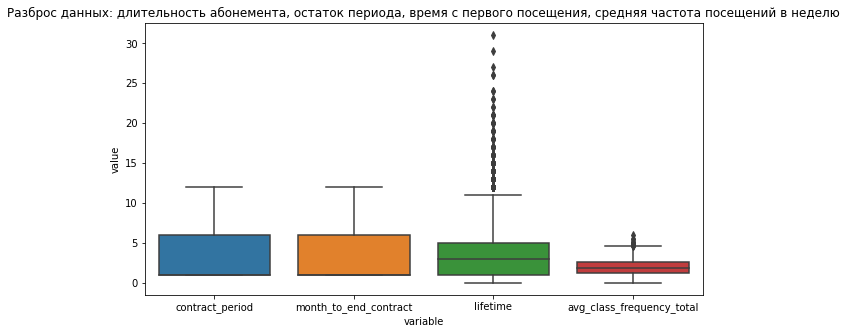

In [24]:
plt.figure(figsize=(10, 5))
df_box = pd.DataFrame(data=df, columns=["contract_period", "month_to_end_contract", "lifetime", "avg_class_frequency_total"])
sns.boxplot(x="variable", y="value", data=pd.melt(df_box))
plt.title('Разброс данных: длительность абонемента, остаток периода, время с первого посещения, средняя частота посещений в неделю')
plt.show()

Судя по диаграммам размаха, выбросы есть у времени с момента первого обращения и средней частоты посещений в неделю. Будет ли это важным для кластеризации юзеров, пока не ясно. 

In [25]:
df_churn = df.groupby('churn').agg('mean')
df_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


IndexError: index 3 is out of bounds for axis 0 with size 3

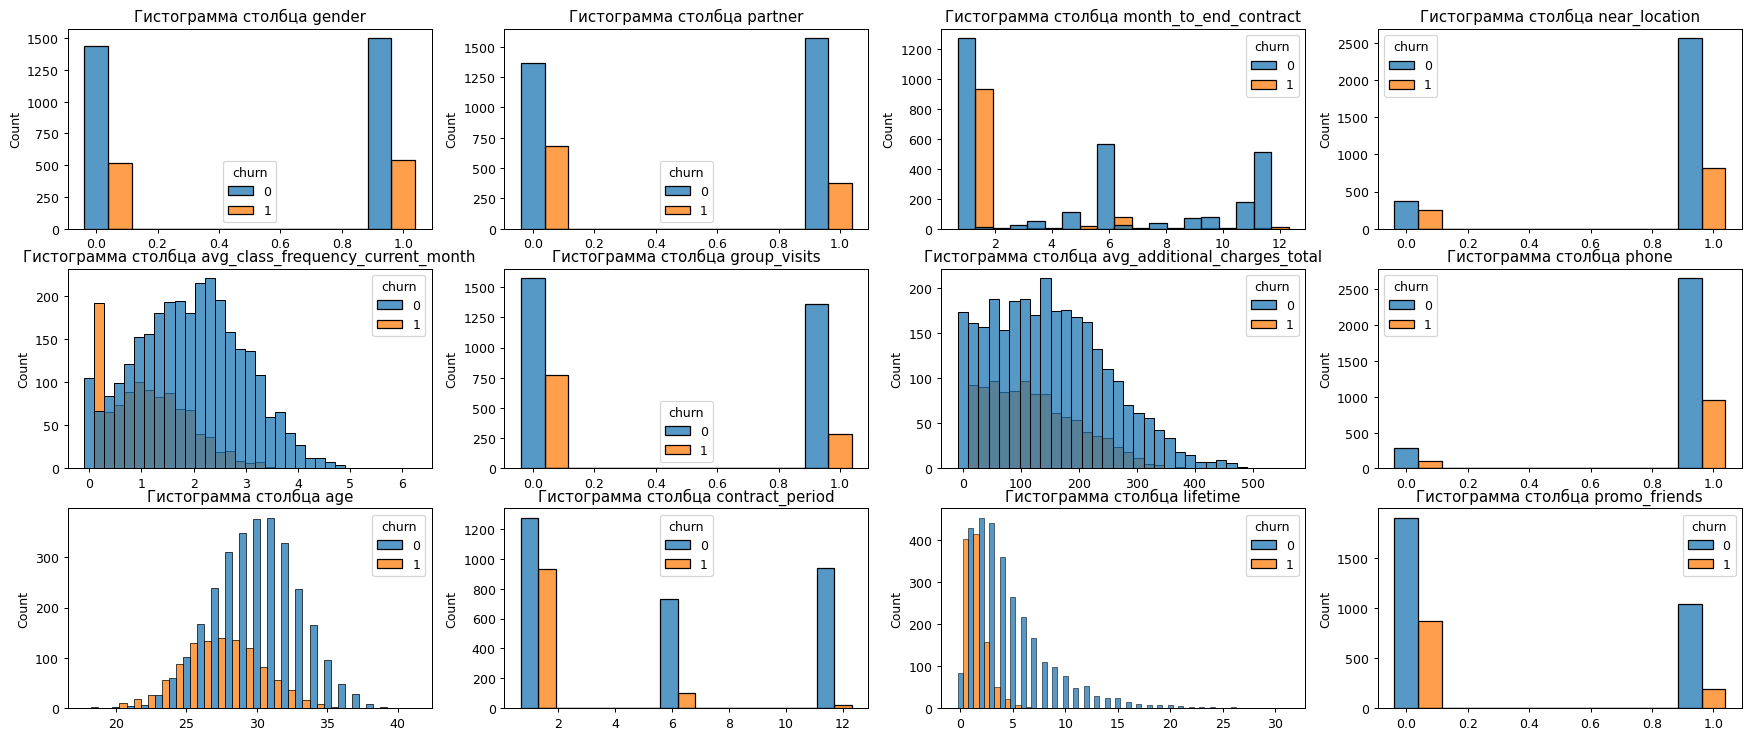

In [26]:
f, axes = plt.subplots(nrows=3, ncols=4, figsize=(24,10), dpi=90)

features = list(set(df.columns[:13]))

for idx, i in enumerate(features):
    sns.histplot(data = df, x=i, hue='churn', multiple='dodge', shrink=2, ax=axes[idx // 4, idx % 4]).set(title = 'Гистограмма столбца ' + i)
    axes[idx // 4, idx % 4].set_xlabel('');

Если говорить о разнице между группами по признаку оттока, то по средним и распределениям видны такие закономерности:

- **группа без оттока** в текущем месяце - в среднем чаще являются сотрдниками компаний-партнеров;
- они же чаще приходят по рекомендации друзей;
- они же заключают более долгие контракты (в среднем ближе к полугоду, в отличие от почти 2-х месяцев у тех, кто ушел в данном месяце). На графике в контрактах с 6 и 12 месяцами группа-0 сильно превышает вторую группу по численности;
- более активны при посещении групповых занятий;
- лайфтайм у группы без оттока больше и хвост длиннее (это их вклад в выбросы по этому признаку);
- примерно на 10% старше тех, кто ушел;
- больше тратят денег на доп. расходы;
- чаще ходят в спортзал в течение недели;
- чаще оставляют свой телефон;

Иными словами клиенты с оттоком=0 более мотивированы на занятия спортом и несколько старше тех, кто быстрее уходит от постоянных занятий;

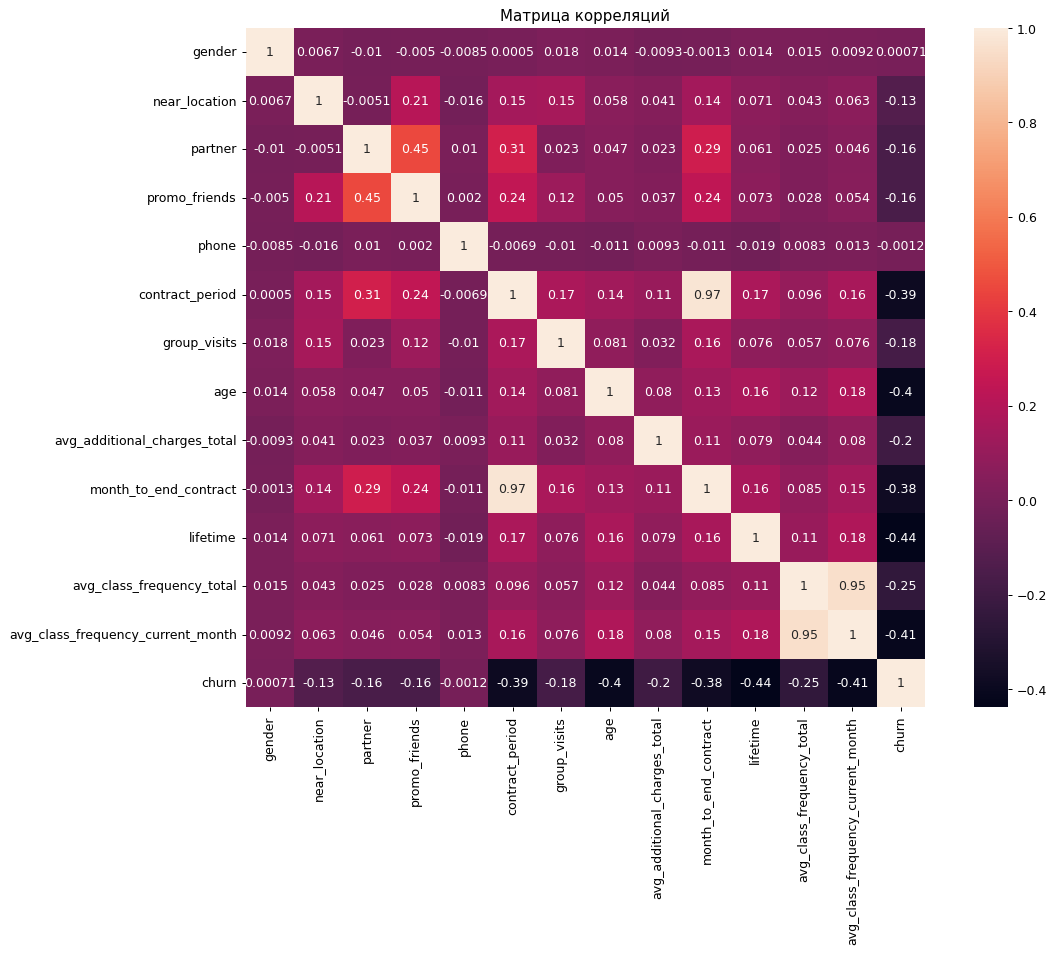

In [27]:
cm = df.corr()

fig, ax = plt.subplots(figsize=(14,10), dpi=90)
sns.heatmap(cm, annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

Судя по матрице корреляций видны связи между следующими признаками:

- сотрудник компании-партнера и рекомендации от друзей;
- сотрудник компании-партнера и период контракта;
- очевидно связаны период контракта и остаток времени до конца контракта, а также частоты посещений в неделю и в текущем месяце;
- также очевидны отрицательные корреляции между оттоком и всем временными показателями;
- есть отрицательная корреляция возраста и оттока;


## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [28]:
X = df.drop(columns=['churn']) 
y = df['churn'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Провери размеры выборок

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3200, 13)
(800, 13)
(3200,)
(800,)


In [30]:
scaler = StandardScaler()
scaler.fit(X)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке методом логистической регрессии

In [31]:
lr_model = LogisticRegression(solver='liblinear', random_state = 0)
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [32]:
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84


Обучим модель на train-выборке методом случайного леса

In [33]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [34]:
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


Если результаты верны, обе модели показали схожие (высокие) результаты на основании выбранных метрик.

## Кластеризация клиентов

Стандартизируем данные. Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.

In [35]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

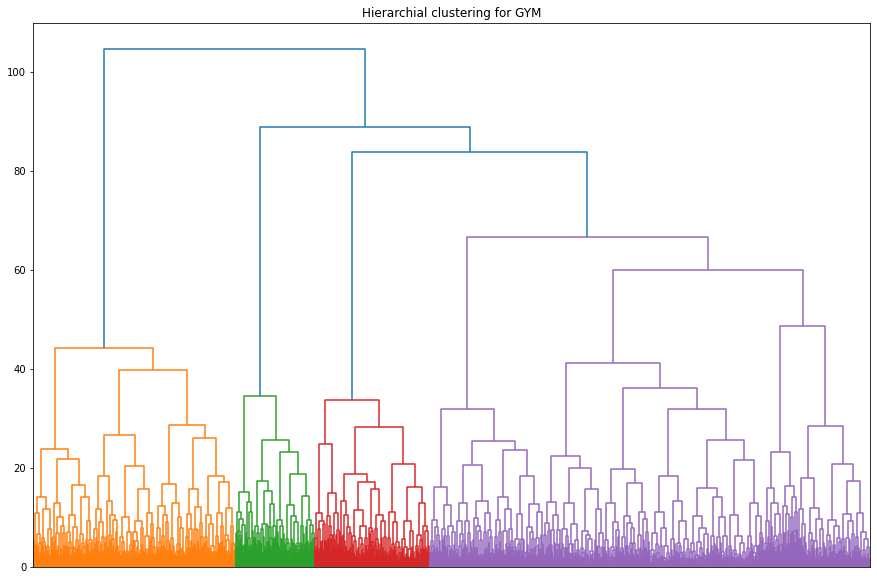

In [36]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Hierarchial clustering for GYM')
plt.show()

Судя по дендрограмме, у нас выделяется 4 кластера. 
В задании рекомендовано взять 5 кластеров, остановимся на этом количестве.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [37]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
df['cluster'] = labels
df.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [38]:
df_churn_cluster = df.groupby('cluster').agg({'churn': 'mean'}).reset_index()
df_churn_cluster.columns = ['cluster', 'churn_mean']
df_churn_cluster

,cluster,churn_mean
0,0,0.027723
1,1,0.267532
2,2,0.443564
3,3,0.514263
4,4,0.068019


Кластеры 1 и 5 - с низким оттоком: живут или работают близко к клубу, чаще других посещают групповые занятия, чуть больше других тратят на доп. расходы, бОльший лайфтайм, чаще ходят в неделю и в текущий месяц. 

Кластер 1 - максимальные длительности контракты (ближе к максимуму в 12 месяцев).

Кластер 5 - не от партнеров и не по рекомендации друзей, невысокая длительность контракта, но высокая активность - ходят на группы, высокая посещаемость в неделю и в текущий месяц.

Кластер 2 - со средним оттоком, средняя длительность контрактов. 

Кластеры 3 и 4 с относительно высоким оттоком (около половины клиентов в каждом кластере), небольшой период контракта, реже остальных ходят на групповые занятия, меньше всех тратят на доп услуги, низкая посещаемость в неделю и в последний месяц.

Как ни странно, кластеры не разделились по возрасту, в каждом в среднем 28-29 лет, и в пятом - самые "старшие", 30 лет. 

In [39]:
df_compare = df[['lifetime', 'avg_class_frequency_current_month', 
                 'contract_period', 'age', 'churn', 'group_visits', 
                 'month_to_end_contract', 'avg_class_frequency_total', 'cluster']]

In [40]:
def show_clusters_on_plot(df_compare, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df_compare[x_name], df_compare[y_name], hue=df_compare[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


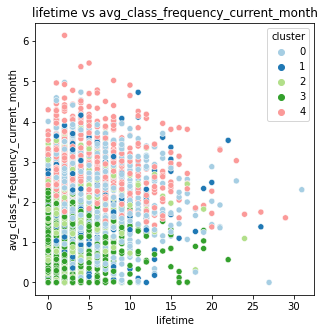

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


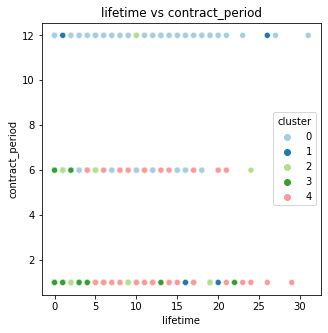

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


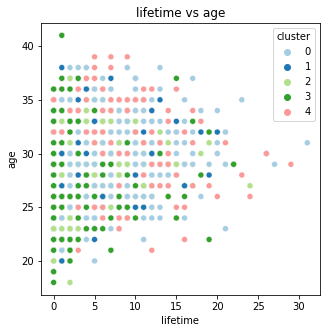

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


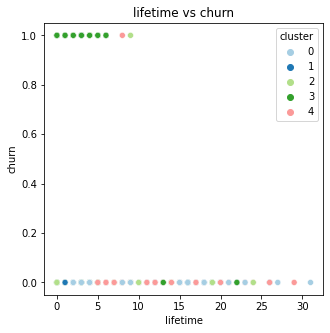

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


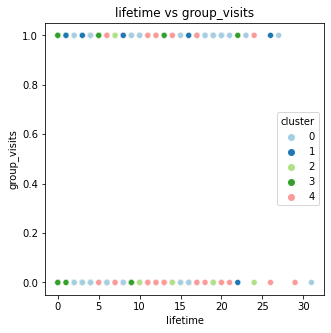

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


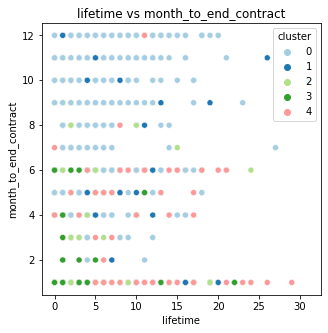

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


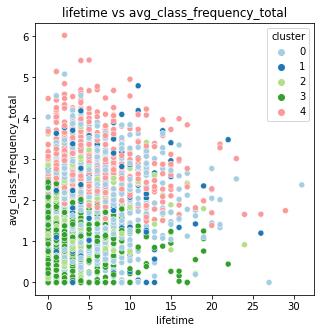

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


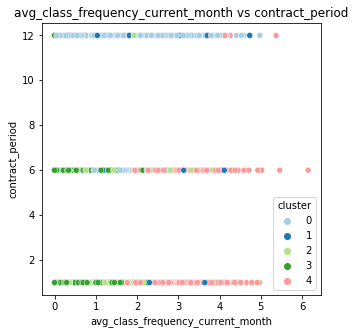

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


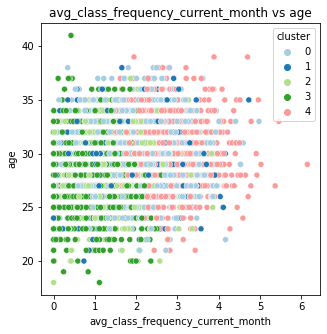

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


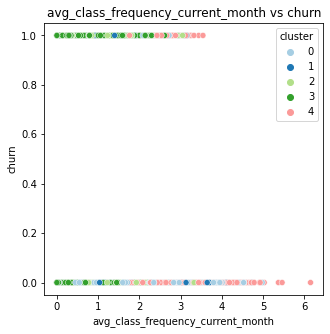

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


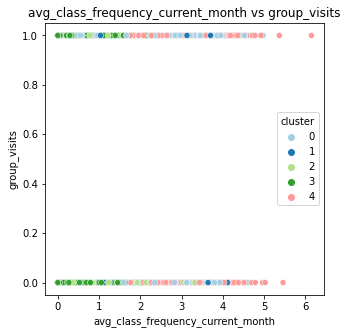

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


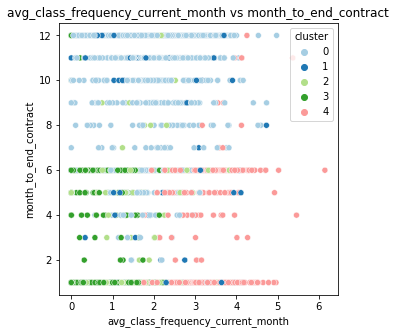

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


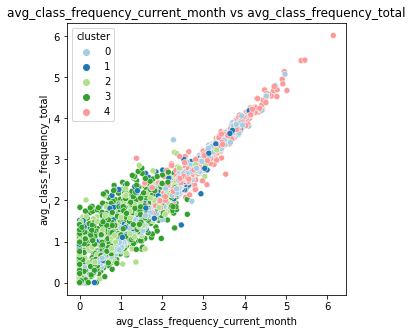

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


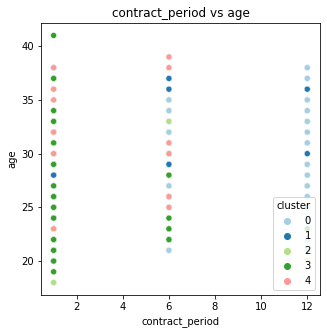

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


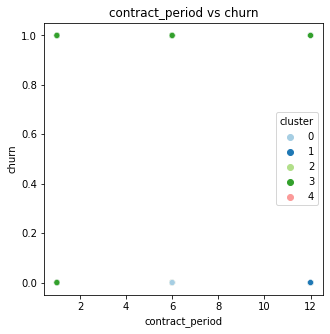

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


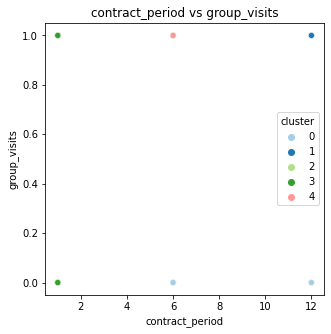

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


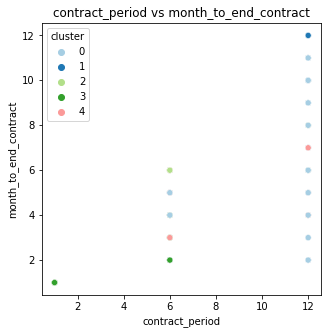

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


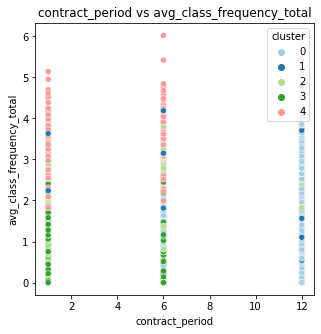

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


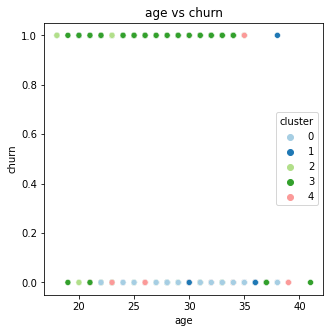

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


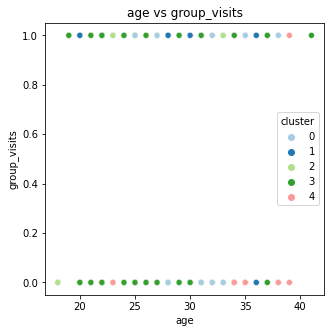

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


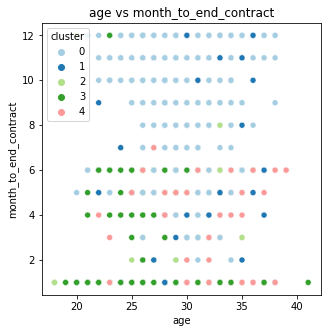

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


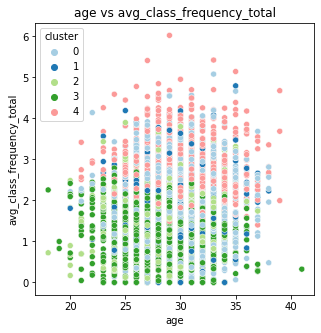

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


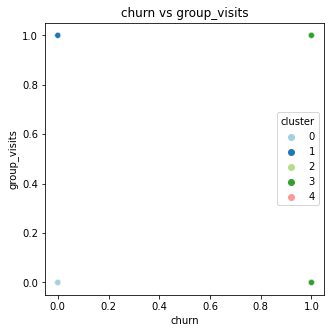

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


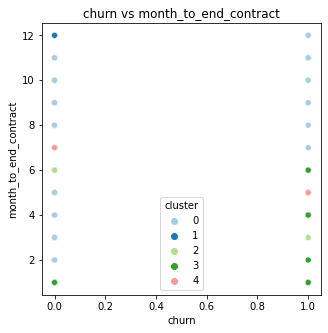

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


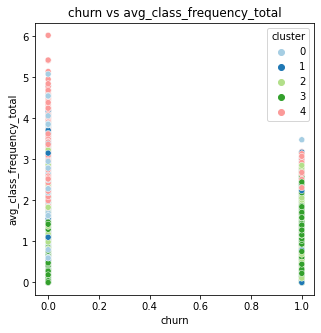

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


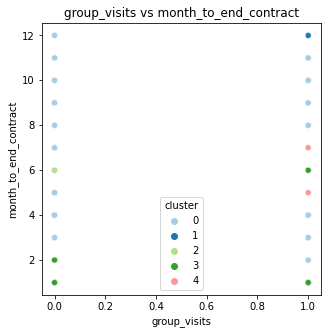

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


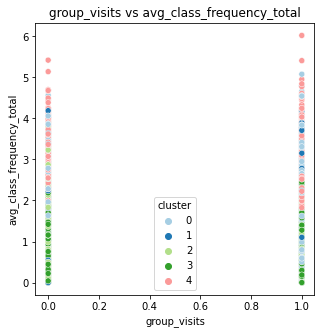

C:\Users\dsaulin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


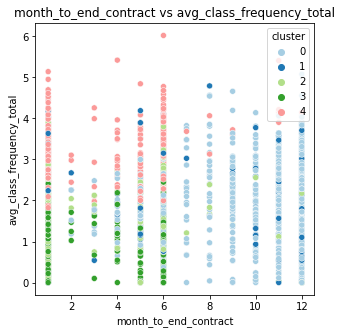

In [41]:
col_pairs = list(combinations(df_compare.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df_compare, pair[0], pair[1], 'cluster')

## Общие выводы

- Для выборки клиентов фитнес-клуба характерны: договор в среднем на 5 месяцев, умеренная активность и посещаемость ок 2-х раз в неделю, возраст около 30 лет, отток клиентов - ок 26%. В основном данные демонстрируют небольшое стандартное отклонение, исключение - выбросы в лайфтайме и средней частоты посещений в неделю.

- Клиентов можно группировать по признаку оттока, и эти группы резко отличаются друг от друга. Если коротко, то клиенты с оттоком равным "0" более мотивированы на занятия спортом и несколько старше тех, кто быстрее уходит от постоянных занятий.

- Есть корреляции между признаками "сотрудник компании-партнера" и "рекомендации от друзей", а также "сотрудник компании-партнера" и "период контракта", есть отрицательная корреляция возраста и оттока.

- Обе модели (линейной регрессии и методом случайного леса) показали схожие (высокие) результаты прогнозирования на основании выбранных метрик. 

- Дендрограмма позволила выделить 4 кластера клиентов. Алгоритм K-Means мы строили по 5 возможным кластерам. 

- Кластер 1 (**"Лояльные активисты"**) - низкий отток, максимальные длительности контракты (ближе к максимуму в 12 месяцев), чаще других посещают групповые занятия, чуть больше других тратят на доп. расходы 

- Кластер 5 (**"Начинающие активисты"**) - низкий отток, не от партнеров и не по рекомендации друзей, невысокая длительность контракта, но высокая активность - ходят на группы, высокая посещаемость в неделю и в текущий месяц.

- Кластер 2 (**"Середняки"**) - со средним оттоком, средняя длительность контрактов.

- Кластеры 3 и 4 (**"Нелояльные"**) с относительно высоким оттоком (около половины клиентов в каждом кластере), небольшой период контракта, реже остальных ходят на групповые занятия, меньше всех тратят на доп услуги, низкая посещаемость в неделю и в последний месяц, чуть моложе остальных кластеров. 

Нам кажется, что клуб может увеличить посещаемость клуба и средний чек за счет:

- удержания "нелояльных" (отдельный вопрос, почему у них короткие контракты - вполне возможно, что причина заключается в продаже коротких фитнес-контрактов изначально немотивированной молодежи); 
- снижения риска перехода "начинающих активистов" в кластер "нелояльных";
- анализ потребностей "середняков";
- поиск потенциальных клиентов среди молодежи младше 28 лет и публики старше 30 лет, если ресурсы клубы на это рассчитаны; 